In [1]:
# Define the directory containing the data
#experiment_names = ["test", "test2", "test3", "test4", "test5_top_p", "test6_all_timeprompt_gpt3.5_1000"]  # Replace with your actual experiment names
experiment_names = ["test"]

CUDA is available. Using GPU.
Epoch [1/50], Loss: 0.2538
Epoch [2/50], Loss: 0.2475
Epoch [3/50], Loss: 0.2338
Epoch [4/50], Loss: 0.2133
Epoch [5/50], Loss: 0.1867
Epoch [6/50], Loss: 0.1585
Epoch [7/50], Loss: 0.1310
Epoch [8/50], Loss: 0.1056
Epoch [9/50], Loss: 0.0832
Epoch [10/50], Loss: 0.0643
Epoch [11/50], Loss: 0.0489
Epoch [12/50], Loss: 0.0369
Epoch [13/50], Loss: 0.0278
Epoch [14/50], Loss: 0.0212
Epoch [15/50], Loss: 0.0165
Epoch [16/50], Loss: 0.0133
Epoch [17/50], Loss: 0.0112
Epoch [18/50], Loss: 0.0098
Epoch [19/50], Loss: 0.0090
Epoch [20/50], Loss: 0.0085
Epoch [21/50], Loss: 0.0082
Epoch [22/50], Loss: 0.0080
Epoch [23/50], Loss: 0.0079
Epoch [24/50], Loss: 0.0078
Epoch [25/50], Loss: 0.0078
Epoch [26/50], Loss: 0.0078
Epoch [27/50], Loss: 0.0077
Epoch [28/50], Loss: 0.0077
Epoch [29/50], Loss: 0.0077
Epoch [30/50], Loss: 0.0077
Epoch [31/50], Loss: 0.0077
Epoch [32/50], Loss: 0.0077
Epoch [33/50], Loss: 0.0077
Epoch [34/50], Loss: 0.0077
Epoch [35/50], Loss: 0.0077

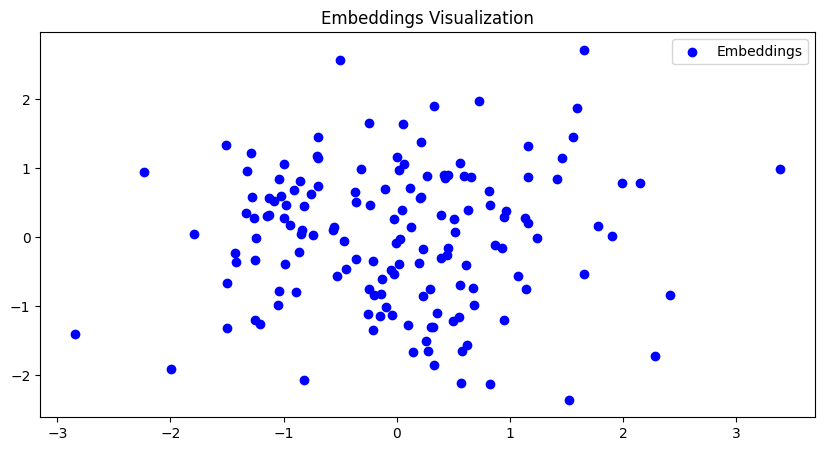

In [2]:
import os
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
else:
    print("CUDA is not available. Using CPU.")

data_dirs = [f"data/{exp}" for exp in experiment_names]

# Define a custom dataset class
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, texts):
        self.embeddings = embeddings
        self.texts = texts

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.texts[idx]

# Initialize lists to store the data
embeddings_list = []
original_texts = []

# Iterate through each data directory to load data
for data_dir in data_dirs:
    for step in sorted(os.listdir(data_dir)):
        step_dir = os.path.join(data_dir, step)
        if os.path.isdir(step_dir):
            uuid_response_file = os.path.join(step_dir, 'uuid_response_list.json')

            if os.path.exists(uuid_response_file):
                # Load UUID response data
                with open(uuid_response_file, 'r') as f:
                    uuid_responses = json.load(f)

                # Collecting embedding data
                embeddings_dir = os.path.join(step_dir, 'embeddings')
                if os.path.exists(embeddings_dir):
                    for embed_file in os.listdir(embeddings_dir):
                        if embed_file.endswith('.json'):
                            with open(os.path.join(embeddings_dir, embed_file), 'r') as f:
                                embed_data = json.load(f)
                                combined_embedding = np.concatenate(
                                    [embedding_entry['embedding'] for embedding_entry in embed_data['embeddings']],
                                    axis=None
                                )
                                embeddings_list.append(combined_embedding)
                                response_uuid = embed_data['uuid']

                                # Find the corresponding original text from uuid_responses
                                for response in uuid_responses:
                                    if response['uuid'] == response_uuid:
                                        original_texts.append(response['response_content'])
                                        break

# Ensure embeddings are of the same length
max_embedding_length = max(len(embed) for embed in embeddings_list)
embeddings_list = [np.pad(embed, (0, max_embedding_length - len(embed)), 'constant') for embed in embeddings_list]

# Convert embeddings to a NumPy array and normalize
embeddings = np.array(embeddings_list, dtype=np.float32)
scaler = StandardScaler()
embeddings = scaler.fit_transform(embeddings)

# Convert texts to one-hot vectors
vocab = set(' '.join(original_texts))
char2idx = {char: idx for idx, char in enumerate(vocab)}
idx2char = {idx: char for char, idx in char2idx.items()}
max_len = max(len(text) for text in original_texts)

def text_to_onehot(text):
    onehot = np.zeros((max_len, len(vocab)), dtype=np.float32)
    for i, char in enumerate(text):
        onehot[i, char2idx[char]] = 1.0
    return onehot

onehot_texts = np.array([text_to_onehot(text) for text in original_texts])

# Create dataset and dataloaders
dataset = EmbeddingDataset(embeddings, onehot_texts)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Define the autoencoder model
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

input_dim = embeddings.shape[1]
hidden_dim = 128
output_dim = onehot_texts.shape[1] * onehot_texts.shape[2]

model = AutoEncoder(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the autoencoder
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for embeddings_batch, texts_batch in train_loader:
        embeddings_batch = embeddings_batch.to(device)
        texts_batch = texts_batch.view(texts_batch.size(0), -1).to(device)

        outputs = model(embeddings_batch)
        loss = criterion(outputs, texts_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}")

# Evaluating the autoencoder
model.eval()
test_loss = 0
with torch.no_grad():
    for embeddings_batch, texts_batch in test_loader:
        embeddings_batch = embeddings_batch.to(device)
        texts_batch = texts_batch.view(texts_batch.size(0), -1).to(device)

        outputs = model(embeddings_batch)
        loss = criterion(outputs, texts_batch)
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

# Save the trained model
torch.save(model.state_dict(), 'autoencoder_model.pth')

# Visualize the original and reconstructed texts
def onehot_to_text(onehot):
    chars = [idx2char[idx] for idx in onehot.argmax(axis=1) if idx in idx2char]
    return ''.join(chars)

model.eval()
original_texts_sample = []
reconstructed_texts_sample = []

for embeddings_batch, texts_batch in test_loader:
    embeddings_batch = embeddings_batch.to(device)
    texts_batch = texts_batch.view(texts_batch.size(0), -1).to(device)

    with torch.no_grad():
        outputs = model(embeddings_batch).cpu().numpy()

    for i in range(len(texts_batch)):
        original_texts_sample.append(onehot_to_text(texts_batch[i].cpu().numpy().reshape(max_len, -1)))
        reconstructed_texts_sample.append(onehot_to_text(outputs[i].reshape(max_len, -1)))

    if len(original_texts_sample) >= 5:
        break

for i in range(5):
    print(f"Original Text {i+1}: {original_texts_sample[i]}")
    print(f"Reconstructed Text {i+1}: {reconstructed_texts_sample[i]}")
    print("-----")

# Visualize embeddings
plt.figure(figsize=(10, 5))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c='blue', label='Embeddings')
plt.title('Embeddings Visualization')
plt.legend()
plt.show()
